<font face="Times New Roman">
<div dir=ltr align=center>
<font color=3C99D size=6>
    Metagenomics Binning

In this notebook, we analysis metagenomics reads and bin them using BusyBee. You can download the [data](https://github.com/algbioi/datasets/blob/master/simulated_dataset_uniform.7z) here.

In [1]:
import csv
import numpy as np
import matplotlib.pyplot as plt

raw_data = []
with open('../data/simulated_dataset_uniform.fna', encoding='windows-1252') as fasta:
    raw_data = fasta.readlines()

contigs_dict = dict()
contigs = []
contigs_len = []
cur_key = ''
for line in raw_data:
    if line[0] == ">":
        cur_key = line[1:].strip()
    else:
        contigs_dict[cur_key] = line.strip()
        contigs.append(line.strip())
        contigs_len.append(len(line.strip()))

sorted_contigs_len = np.sort(contigs_len, kind='mergesort')

In [2]:
output = """contigs count = %s
contigs min length= %s
contigs max length = %s
contigs mean length = %s
contigs median length = %s
contigs standatd deviation length = %s
contigs variance length = %s"""
print(output % (len(contigs), min(contigs_len), max(contigs_len, ),
                np.mean(contigs_len), np.median(sorted_contigs_len),
                np.std(contigs_len), np.var(contigs_len)))

contigs count = 14393
contigs min length= 1000
contigs max length = 709034
contigs mean length = 9904.569999305219
contigs median length = 3531.0
contigs standatd deviation length = 22002.540709220997
contigs variance length = 484111797.66092724


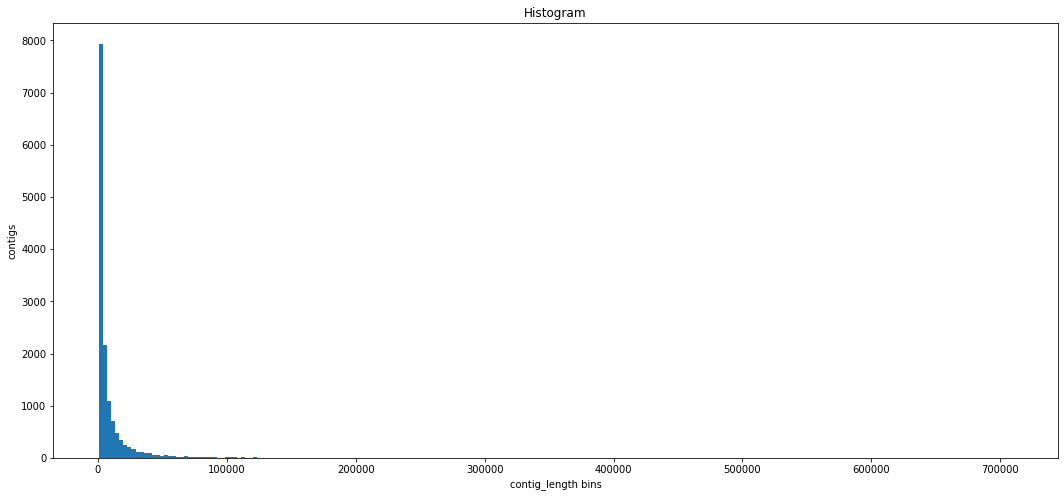

In [3]:
fig, ax = plt.subplots(figsize =(18, 8))
ax.hist(contigs_len, bins='scott')
ax.set_xlabel('contig_length bins')
ax.set_ylabel('contigs')
plt.title('Histogram')
plt.show()

In [4]:
gt = dict()
gt_contig_id_as_key = dict()
with open('../data/simulated_dataset_uniform.csv') as csvfile:
    row = csv.reader(csvfile)
    for r in row:
        d = r[0].split()
        if d[1] in gt.keys():
            gt[d[1]] += [d[0]]
        else:
            gt[d[1]] = [d[0]]

        gt_contig_id_as_key[d[0]] = d[1]
        
print("species count = %s" % (len(gt.keys())))

species count = 47


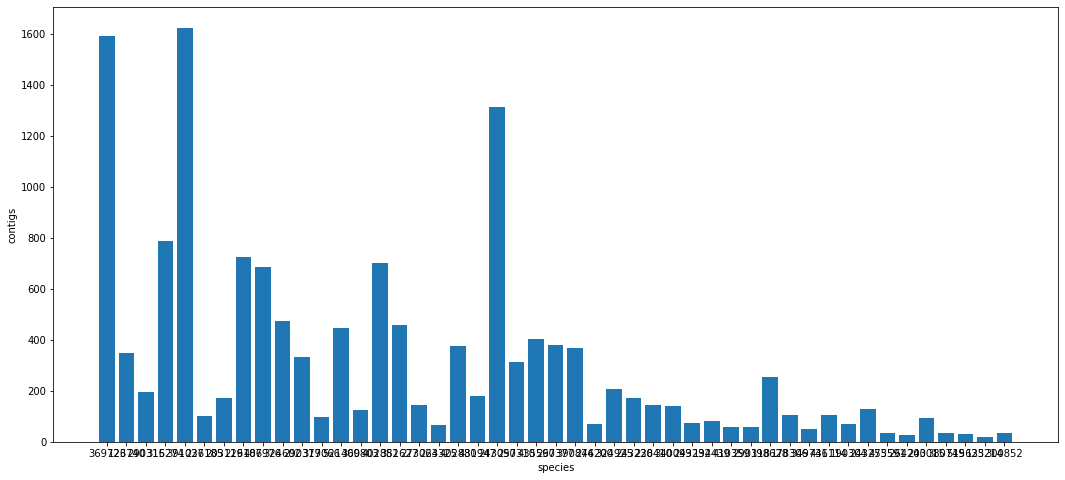

In [5]:
fig, ax = plt.subplots(figsize =(18, 8))
ax.bar(gt.keys(), [len(v) for v in gt.values()])
ax.set_xlabel('species')
ax.set_ylabel('contigs')
plt.show()

contigs	nucleotides
369723:	4829418
126740:	1088662
290315:	2781039
316274:	6178235
391037:	5012206
226185:	3208329
203119:	3647590
226186:	6059325
407976:	2779346
324602:	5119017
290317:	2988698
379066:	4634778
521460:	2762905
309803:	1783922
402882:	2840971
351627:	2784671
273063:	2703912
224325:	2235488
402880:	1793736
431947:	2231291
243090:	6852486
257310:	5280312
435590:	4999157
267377:	1737283
390874:	1360402
246200:	4091479
324925:	3014089
243230:	3168742
228410:	2733991
340099:	2286108
243232:	1682686
194439:	2308174
410359:	2184406
290318:	2026555
198628:	4836907
178306:	2265207
349741:	2657539
436114:	1890195
190304:	2146315
243275:	2898261
453591:	1304151
264203:	2051095
240015:	4112850
380749:	1549772
515635:	1843217
123214:	1928041
300852:	1883517


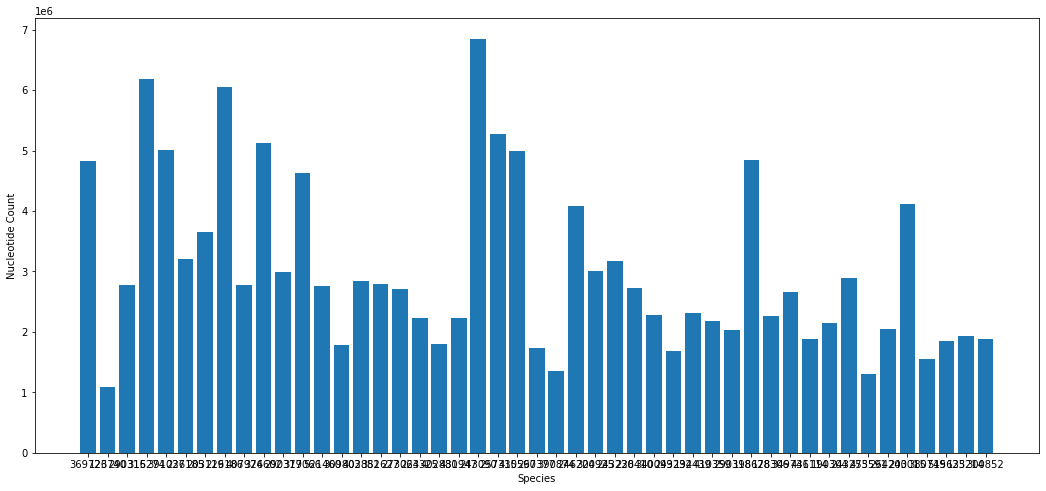

In [6]:
nucleotide_count = [sum([len(contigs_dict[r]) for r in v if (r in contigs_dict.keys())]) for v in gt.values()]
print("contigs\tnucleotides")
for i, k in enumerate(gt.keys()):
    print("%s:\t%s" % (k, nucleotide_count[i]))

fig, ax = plt.subplots(figsize =(18, 8))
ax.bar(gt.keys(), nucleotide_count)
ax.set_xlabel('Species')
ax.set_ylabel('Nucleotide Count')
plt.show()

In [7]:
clusters = dict()
clusters_contig_id_as_key = dict()
with open('../data/contigs.cluster.table.tsv') as csvfile:
    lines = csv.reader(csvfile, delimiter="\t")
    for l in lines:
        if int(l[1]) in clusters.keys():
            clusters[int(l[1])] += [l[0].strip()]
        else:
            clusters[int(l[1])] = [l[0].strip()]
        
        clusters_contig_id_as_key[l[0].strip()] = l[1]

contigs with cluster 0 (noise points) = 706
contigs without cluster (border points) = 4285


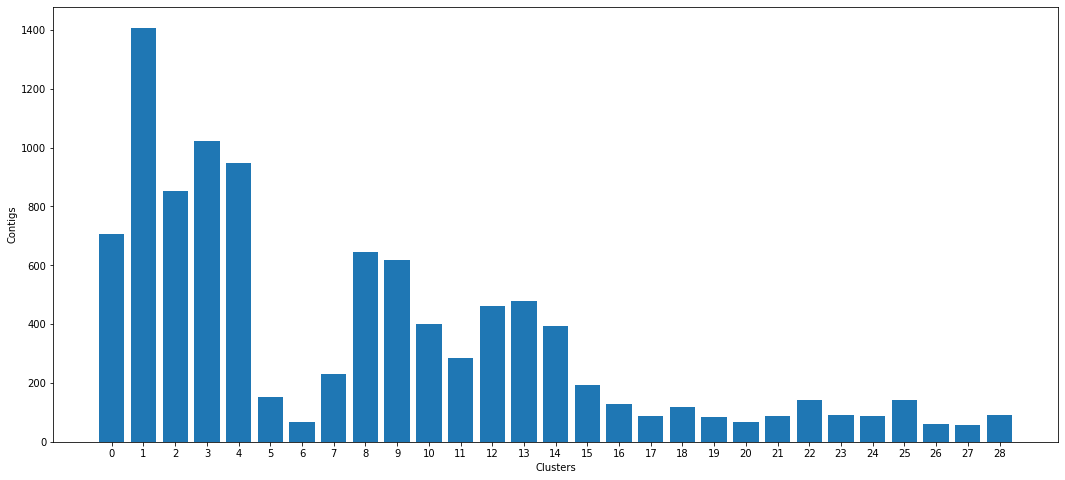

In [8]:
sorted_keys = np.sort(list(clusters.keys()), kind='mergesort')
cluster_count = []
for k in sorted_keys:
    cluster_count.append(len(clusters[k]))
    
print("contigs with cluster 0 (noise points) = %s" % (cluster_count[0]))
print("contigs without cluster (border points) = %s" % (len(contigs_dict.keys())-
                                                        len(clusters_contig_id_as_key.keys())))
fig, ax = plt.subplots(figsize =(18, 8))
ax.bar(sorted_keys, cluster_count)
ax.set_xlabel('Clusters')
ax.set_ylabel('Contigs')
plt.xticks(sorted_keys)
plt.show()

In [9]:
busybee_dict = dict()
with open('../data/contigs.bin.table.tsv') as csvfile:
    lines = csv.reader(csvfile, delimiter='\t')
    for l in lines:
        busybee_dict[l[0].strip()] = l[1]

In [10]:
file1 = ["""@Version:0.9.1
@SampleID:id_1

@@SEQUENCEID\tBINID\tLENGTH"""]

file2 = ["""@Version:0.9.1
@SampleID:id_1

@@SEQUENCEID\tBINID"""]

for k in gt_contig_id_as_key.keys():
    if k not in clusters[0]:
        file1.append("%s\t%s\t%s\t" % (k, gt_contig_id_as_key[k], len(contigs_dict[k])))
        file2.append("%s\t%s" % (k, busybee_dict[k]))

with open('../data/amber/input/gold_standard_file.binning', 'w') as file:
    file.write('\n'.join(file1))
with open('../data/amber/input/busybee_bin.binning', 'w') as file:
    file.write('\n'.join(file2))